# Deep Learning Project (DD2424)


## -- INITIAL SETUP --

### 0.1 Download datasets

In [ ]:
download_data = False

In [13]:

if download_data:
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
    !wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

    !mkdir oxford-iiit-pet/
    !tar -xf images.tar.gz -C oxford-iiit-pet/
    !tar -xf annotations.tar.gz -C oxford-iiit-pet/
    !rm images.tar.gz
    !rm annotations.tar.gz

else:
    print("Note: Assuming that data is manually downloaded!")
    # --> Alternative is to manually download datasets here: https://www.robots.ox.ac.uk/~vgg/data/pets/
    #  Note: must have the folder "oxford-iiit-pet" in same directory as code/notebook

Note: Assuming that data is manually downloaded!


### 0.2 Define Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torchvision

from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchvision.ops.boxes import masks_to_boxes

from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import transforms

### 0.3 Example plot

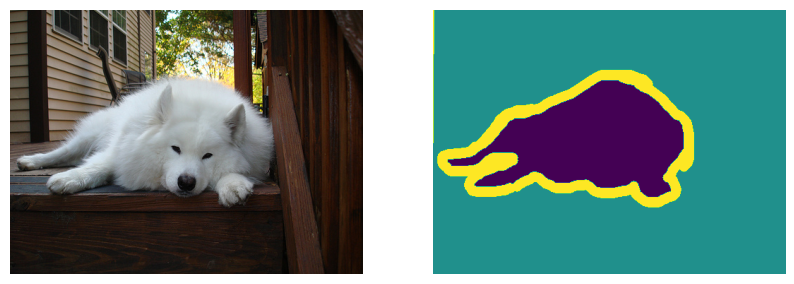

In [5]:
from torchvision.io import read_image

# -- PLOT EXAMPLE IMAGE AND MASK --
name = 'samoyed_142'
img = read_image(f'oxford-iiit-pet/images/{name}.jpg')
mask = read_image(f'oxford-iiit-pet/annotations/trimaps/{name}.png')

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)
plt.imshow(mask.permute(1, 2, 0))
plt.axis('off')
plt.show()

## -- DATA PREPROCESSING --


### 1.1 Define datasets and dataloaders and subset splits (train, validation, test):

In [6]:
def load_dataset():
    # Load in all the data within file 'trainval.txt'
    return OxfordIIITPet(
    root='.',
    download=False,
    transform=transform_pipeline,
    target_transform=target_transform,   # TODO: Figure out what this is and why the 'target_transform' function returns it's input
    target_types=["category"],  # ["binary-category"]
    )


def transform_pipeline(in_data):
    # Define an ordered collection of functions/transformation that we want to apply to all our images (pre-processing)
    pipeline = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
    ])
    return pipeline(in_data)


def target_transform(target):
    return target


def create_split_idxs(n_tot, f_train=0.8, f_valid=0.1, f_test=0.1):

    if f_train + f_valid + f_test > 1:
        print("ERROR: FACTORS TOO LARGE TO CREATE SPLITS, TRY AGAIN")

    # Range from index 0 to n==len(dataset)
    idxes = np.arange(n_tot)
    np.random.seed(42)   # random seed to ensure repeatability
    np.random.shuffle(idxes)

    # split limits:
    s1 = int(n_tot*f_train)
    s2 = int(n_tot*(f_train+f_valid))

    # Create index lists
    train_idx = idxes[:s1]
    val_idx = idxes[s1:s2]
    test_idx = idxes[s2:]

    return train_idx, val_idx, test_idx


def get_dataloaders():
    # Load in all data
    dataset = load_dataset()

    # Create shuffled index splitting for each subset
    train_idx, val_idx, test_idx = create_split_idxs(len(dataset))

    # Split using imported Subset class
    dataset_train = Subset(dataset, train_idx)
    dataset_test = Subset(dataset, test_idx)
    dataset_val = Subset(dataset, val_idx)

    # Create data loader containing datasets
    dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
    dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=0)
    dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True, num_workers=0)

    return dataloader_train, dataloader_test, dataloader_val


### 1.2 Plot random example images to show pre-processing (scaling and cropping)

7349
2


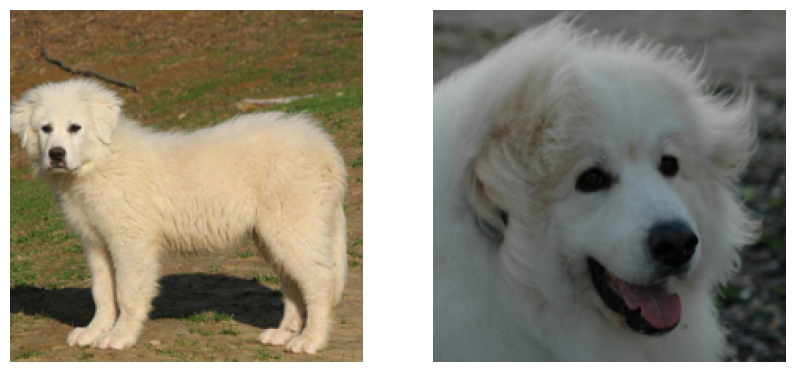

In [25]:
dataset = load_dataset()

# plot example image
plt.figure(figsize=(10, 10))
plt.subplot(121)

plt.imshow(dataset[2600][0].permute(1, 2, 0))
plt.axis('off')
plt.subplot(122)

plt.imshow(dataset[2628][0].permute(1, 2, 0))
plt.axis('off')

plt.show()


### (maybe todo) 1.3 Define zero-mean normalization across all data

In [91]:
def zero_mean(dataloader):
    # TODO: FIXME IF WE WANT TO DO ZERO MEAN NORMALIZATION

    #print(next(iter(dataloader_test))[0].shape)  # torch.Size([64, 3, 224, 224])
    #img = next(iter(dataloader_test))[0][0]
    #print(img.max())
    #print(img.min())
    #print(max(next(iter(dataloader_test))))

    img, _ = next(iter(dataloader))
    img = img[0]
    print(f'max: {torch.max(img)}')
    print(f'min: {torch.min(img)}')
    print(f'mean: {torch.mean(img)}')


tensor(0.8980)
tensor(0.)


## -- NETWORK SETUP --

### 2.0 Network Imports

In [118]:
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
#from torchvision.models import resnet101
#from torchvision.models import resnet152

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### 2.1 Define model and training functions

In [138]:
def create_model_and_optim():

    # Load in pretrained model of our choice:
    model = resnet34(weights='DEFAULT')   # Using best (pretrained?) weights with "DEFAULT"

    # As instructed, only replace final layer with same in but one out (cat/dog)
    in_features = model.fc.in_features   # size of input of final layer --> 512
    #print(model.fc.out_features)   # size of output into final layer --> 1000

    # Create a new Linear layer to replace last fc layer with:
    model.fc = torch.nn.Linear(in_features, 1)  # for binary classification instead of outputting 1000

    # Freeze all layers before final layer which we will replace
    for param in model.parameters():
        param.requires_grad = False

    for param in model.fc.parameters():
        param.requires_grad = True   # update these layer weights (only last)

    optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.0005)

    return model, optimizer


def train(model, dataloader, optimizer, epochs=1):
    losses = []

    #model.train()

    n_batch = 64

    for _ in range(epochs):
        for i, (img, binary_category) in tqdm(enumerate(dataloader)):
            img = img.to("cuda")
            binary_category = binary_category.to("cuda")

            output = model(img)

            loss = torch.nn.BCEWithLogitsLoss()(output, binary_category.view(-1, 1).float())
            loss.backward()   # calculate grads

            if i % n_batch == 0:
                optimizer.step()  # update weights with grads
                losses.append(loss)
                optimizer.zero_grad()  # reset grads

    return losses


### 2.2 Define metrics

In [ ]:
# TODO: FIXME
def compute_accuracy(model, dataloader_test):
    total = 0
    correct = 0

    # no grad so it's faster (--> Julia edit: 'no_grad()' ensures that we can calculate with tensors without affecting it's gradients in backprop)
    with torch.no_grad():

        model.eval()

        for i, (img, binary_category) in tqdm(enumerate(dataloader_test)):
            img = img #.to("cuda")
            binary_category = binary_category #.to("cuda")

            output = model(img)
            prediction = torch.round(torch.sigmoid(output))

            total += binary_category.size(0)
            correct += (prediction == binary_category).sum().item()

        print(f'\nAccuracy: {100 * correct // total} %')




### 2.3 Define plotting functions

In [139]:
def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_losses(losses):
    losses_cpu = [loss.cpu().detach().numpy() for loss in losses]
    plt.plot(smooth(losses_cpu))

## -- NETWORK TRAINING --

### 2.3 Initialize data

In [ ]:
dataloader_train, dataloader_test, dataloader_val = get_dataloaders()

### 2.3 Initialize model, train, and plot losses

In [140]:
print(f"cuda == {torch.cuda.is_available()}")

model, optimizer = create_model_and_optim()

#model.to("cuda")
losses = train(model, dataloader_train, optimizer, epochs=3)


### 2.4 Evaluate and plot losses

In [ ]:
plot_losses(losses)

compute_accuracy(model, dataloader_test)

### 2.

### 2.

### 2.

### 2.

### 2.